# Introduction

The U-Net is a type of convolutional neural network (CNN) that's specifically designed for accurate segmentation of images.



![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

> The illustration depicts the U-Net architecture, using 32x32 pixels at the lowest resolution as an example. In this diagram, each blue box represents a multi-channel feature map. The quantity of channels for each feature map is indicated above the corresponding box, while the spatial dimensions (x-y size) are indicated at the lower left corner of the box. Boxes in white denote feature maps that have been copied from a previous layer. The arrows present in the diagram symbolize various operations carried out in the architecture.
>
> Please note that while this illustration serves as an example of the U-Net architecture, the actual dimensions or layout of the layers can vary, depending on specific use cases or modifications to the architecture.

# Importing Libraries

In [14]:
import tensorflow as tf
import zipfile
import numpy as np
import random
import os
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [15]:
SEED = 42
np.random.seed = SEED

#UNZIP_PATH = 'data-science-bowl-2018'
TRAIN_PATH = 'train/'
TEST_PATH = 'test/'

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Loading and Unzipping Dataset

In [16]:
# Unzip data
with zipfile.ZipFile('stage1_train.zip', 'r') as zip_ref:
    zip_ref.extractall('train')
    
with zipfile.ZipFile('stage1_test.zip', 'r') as zip_ref:
    zip_ref.extractall('test')

In [17]:
# get list of all subfolders
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [18]:
# define placeholders (also used to replace NaN in images to resize by 0)
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = bool)

# Setting Groundtruths

In [20]:
# Loop through all train_ids
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):  
    
    # Get the path to the image and mask directories
    path = TRAIN_PATH + id_  
    
    # Read the image and keep the first IMG_CHANNELS channels
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]  
    
    # Resize the image to IMG_HEIGHT x IMG_WIDTH while keeping the pixel values (mode='constant')
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)  
    
    # Store the processed image into the X_train array at index n
    X_train[n] = img 
    
    # Initialize an empty mask of dimensions IMG_HEIGHT x IMG_WIDTH x 1 with boolean values
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)  
    
    # Loop through each file in the masks directory
    for mask_file in next(os.walk(path + '/masks/'))[2]:  
        
        # Read the mask file
        mask_ = imread(path + '/masks/' + mask_file)
        
        # Resize the mask to IMG_HEIGHT x IMG_WIDTH while keeping the pixel values (mode='constant'), and add an extra dimension
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        
        # Merge all the masks associated with the same image by taking the maximum value at each pixel location
        mask = np.maximum(mask, mask_)
    
    # Store the processed mask into the Y_train array at index n
    Y_train[n] = mask

100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [09:11<00:00,  1.21it/s]


In [21]:
# Create an empty array for test images with dimensions as (number of test images, height, width, channels)
# The datatype for the array is uint8 which can hold values from 0 to 255
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

# Initialize an empty list to store the original sizes of the test images
sizes_test = []

# Loop through all the test_ids
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    
    # Get the path to the test image
    path = TEST_PATH + id_
    
    # Read the image and keep the first IMG_CHANNELS channels
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    
    # Append the original size of the image to sizes_test list
    sizes_test.append([img.shape[0], img.shape[1]])
    
    # Resize the image to IMG_HEIGHT x IMG_WIDTH while keeping the pixel values
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # Store the processed image into the X_test array at index n
    X_test[n] = img

100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 28.28it/s]


# U-Net: A Simple Explanation
Imagine you want to color a detailed map. You start by looking at the big picture (the entire map) to understand its overall structure. Then, you zoom in on specific areas to fill in the details. This is essentially what a U-Net does for images.

U-Net is a type of neural network designed specifically for image segmentation. This means it divides an image into different parts (like foreground and background, or different objects) and assigns a label to each pixel.

How it works:
Downward Path (Encoder):

The network starts by processing the entire image.
It gradually reduces the image size while extracting important features.
This is like zooming out on the map to see the big picture.
Upward Path (Decoder):

The network starts to build a detailed map.
It increases the image size while combining the extracted features with new information.
This is like zooming back into the map and filling in the details.

# Building Our Model

In [22]:
# Create a function for a convolution block
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", 
                               kernel_initializer="he_normal", padding="same")(inputs)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", 
                               kernel_initializer="he_normal", padding="same")(x)
    return x

# Create a function for the expanding path
def upsample_block(inputs, conv_prev, num_filters):
    up = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(inputs)
    concat = tf.keras.layers.concatenate([up, conv_prev])
    conv = conv_block(concat, num_filters)
    return conv

In [23]:
# Inputs
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

# Normalization
s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs) 

# Contraction path
c1 = conv_block(s, 16)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = conv_block(p1, 32)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = conv_block(p2, 64)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = conv_block(p3, 128)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = conv_block(p4, 256)

# Expansive path
c6 = upsample_block(c5, c4, 128)
c7 = upsample_block(c6, c3, 64)
c8 = upsample_block(c7, c2, 32)
c9 = upsample_block(c8, c1, 16)

# Output layer
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [24]:
# Model
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

# Compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                             

In [25]:
# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose = 1, save_best_only = True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir = 'logs')
            ]

# Training Our U-Net

In [26]:
results = model.fit(
    X_train, 
    Y_train, 
    validation_split = 0.1, 
    batch_size = 16, 
    epochs = 25, 
    callbacks = callbacks)

Epoch 1/25


38/38 [==============================] - 35s 726ms/step - loss: 0.5048 - accuracy: 0.7481 - val_loss: 0.2942 - val_accuracy: 0.8092
Epoch 2/25
38/38 [==============================] - 28s 727ms/step - loss: 0.2934 - accuracy: 0.8476 - val_loss: 0.3262 - val_accuracy: 0.9000
Epoch 3/25
38/38 [==============================] - 27s 702ms/step - loss: 0.1952 - accuracy: 0.9303 - val_loss: 0.1668 - val_accuracy: 0.9406
Epoch 4/25
38/38 [==============================] - 26s 680ms/step - loss: 0.1506 - accuracy: 0.9441 - val_loss: 0.1258 - val_accuracy: 0.9503
Epoch 5/25
38/38 [==============================] - 27s 701ms/step - loss: 0.1279 - accuracy: 0.9521 - val_loss: 0.1075 - val_accuracy: 0.9583
Epoch 6/25
38/38 [==============================] - 32s 855ms/step - loss: 0.1208 - accuracy: 0.9547 - val_loss: 0.1070 - val_accuracy: 0.9604
Epoch 7/25
38/38 [==============================] - 29s 767ms/step - loss: 0.1156 - accuracy: 0.9563 - val_loss: 0.1236 - val_accuracy: 0.95

# Getting Predictions From Model

In [27]:
# Predictions
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)
preds_test = model.predict(X_test, verbose = 1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

3/3 [==============================] - 1s 131ms/step


In [28]:
# Function to display images
def display_images(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Input Image:


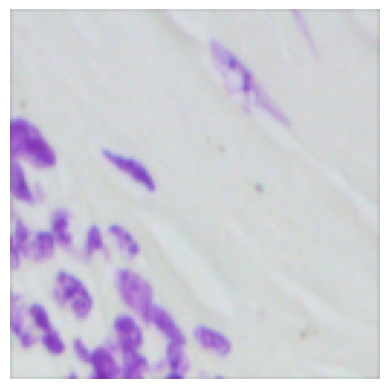

Ground Truth Mask:


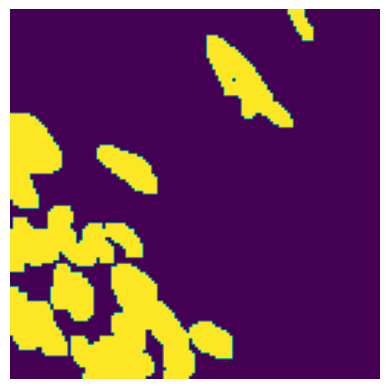

Predicted Mask:


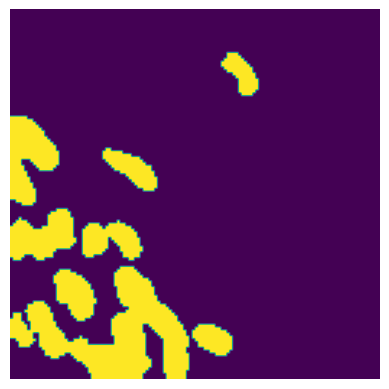

In [29]:
# Select a random index from training set
ix = random.randint(0, len(preds_train_t))

# Display the input image
print("Input Image:")
display_images(X_train[ix])

# Display the ground truth mask
print("Ground Truth Mask:")
display_images(np.squeeze(Y_train[ix]))

# Display the predicted mask
print("Predicted Mask:")
display_images(np.squeeze(preds_train_t[ix]))

Validation Input Image:


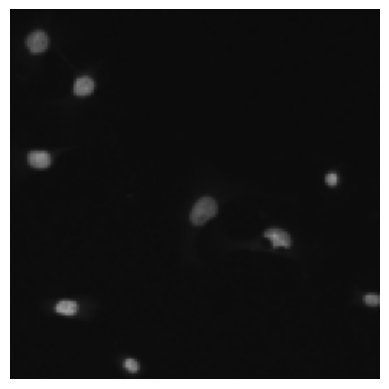

Validation Ground Truth Mask:


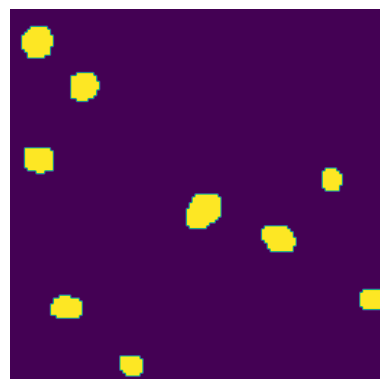

Validation Predicted Mask:


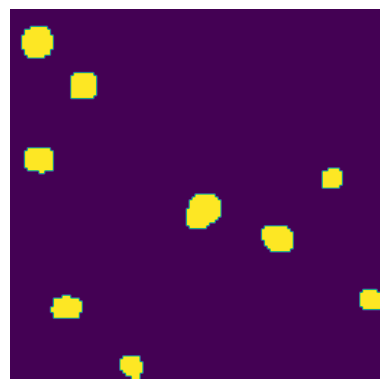

In [30]:
# Select a random index from validation set
ix = random.randint(0, len(preds_val_t))

# Calculate the index from where validation data starts
val_data_start = int(X_train.shape[0] * 0.9)

# Display the validation input image
print("Validation Input Image:")
display_images(X_train[val_data_start:][ix])

# Display the validation ground truth mask
print("Validation Ground Truth Mask:")
display_images(np.squeeze(Y_train[val_data_start:][ix]))

# Display the validation predicted mask
print("Validation Predicted Mask:")
display_images(np.squeeze(preds_val_t[ix]))